<a href="https://colab.research.google.com/github/avanniiii/AvaniAgarwal_102303745_UML501/blob/main/Adaboost_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q scikit-learn pandas matplotlib seaborn nltk tqdm

In [2]:
import os, re, string, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import nltk
try:
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def plot_confusion(cm, labels=[0,1], title="Confusion Matrix"):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title); plt.show()
def print_metrics(y_true, y_pred, name=''):
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
from math import log
def manual_adaboost(X, y, T=15, verbose=True, convert_sparse_threshold=2000):
    y = np.array(y).astype(int)
    n = X.shape[0]
    y_signed = np.where(y==1,1,-1)
    w = np.ones(n)/n
    learners, alphas, errors = [], [], []
    is_sparse = hasattr(X,'toarray') or 'scipy.sparse' in str(type(X))
    convert_to_dense = False
    try:
        n_features = X.shape[1]
    except:
        n_features = None
    if is_sparse and (n_features is None or n_features <= convert_sparse_threshold):
        convert_to_dense = True
    X_work = X.toarray() if convert_to_dense and is_sparse else X
    for t in range(1, T+1):
        clf = DecisionTreeClassifier(max_depth=1, random_state=42)
        try:
            clf.fit(X_work, y, sample_weight=w)
        except Exception:
            if is_sparse:
                X_work = X.toarray()
                clf.fit(X_work, y, sample_weight=w)
            else:
                raise
        pred = clf.predict(X_work)
        pred_signed = np.where(pred==1,1,-1)
        incorrect = (pred_signed != y_signed).astype(int)
        weighted_error = np.dot(w, incorrect)/w.sum()
        weighted_error = np.clip(weighted_error, 1e-12, 1-1e-12)
        alpha = 0.5 * np.log((1-weighted_error)/weighted_error)
        if verbose:
            mis_idx = np.nonzero(incorrect)[0]
            print(f"Iteration {t}: weighted_error={weighted_error:.6f}, alpha={alpha:.6f}")
            print("Misclassified (first 20):", mis_idx[:20].tolist())
            print("Weights of first 20 misclassified:", np.round(w[mis_idx][:20],6).tolist())
        w = w * np.exp(-alpha * y_signed * pred_signed)
        w = w / w.sum()
        learners.append(clf); alphas.append(alpha); errors.append(weighted_error)
    return learners, alphas, errors
def ensemble_predict(learners, alphas, X):
    n = X.shape[0]
    agg = np.zeros(n)
    for clf,a in zip(learners, alphas):
        p = clf.predict(X)
        p_signed = np.where(p==1,1,-1)
        agg += a * p_signed
    return np.where(agg>=0,1,0)
sns.set()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Q1

In [3]:
from google.colab import files
uploaded = files.upload()
SPAM_CSV_PATH = next(iter(uploaded)) if uploaded else 'spam.csv'
df_spam = pd.read_csv(SPAM_CSV_PATH, encoding='latin-1')
if 'v1' in df_spam.columns and 'v2' in df_spam.columns:
    df_spam = df_spam.rename(columns={'v1':'label','v2':'text'})[['label','text']]
elif 'label' in df_spam.columns and 'text' in df_spam.columns:
    df_spam = df_spam[['label','text']]
else:
    df_spam = df_spam.iloc[:, :2]; df_spam.columns = ['label','text']
df_spam['label_num'] = df_spam['label'].map({'ham':0,'spam':1})
PUNCT_TRANSLATOR = str.maketrans('','',string.punctuation)
def preprocess_text(s):
    s = str(s).lower()
    s = s.translate(PUNCT_TRANSLATOR)
    tokens = re.findall(r"\b[a-z]+\b", s)
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)
df_spam['text_clean'] = df_spam['text'].apply(preprocess_text)
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df_spam['text_clean'])
y = df_spam['label_num'].values
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_tfidf, y, df_spam.index.values, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])
print("Train class dist:\n", pd.Series(y_train).value_counts(normalize=True))
print("Test class dist:\n", pd.Series(y_test).value_counts(normalize=True))


Saving spam.csv to spam.csv
Train size: 4457 Test size: 1115
Train class dist:
 0    0.865829
1    0.134171
Name: proportion, dtype: float64
Test class dist:
 0    0.866368
1    0.133632
Name: proportion, dtype: float64


In [4]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
try:
    stump.fit(X_train, y_train)
except:
    stump.fit(X_train.toarray(), y_train)
y_train_pred = stump.predict(X_train if not hasattr(X_train,'toarray') else X_train)
y_test_pred = stump.predict(X_test if not hasattr(X_test,'toarray') else X_test)
print_metrics(y_train, y_train_pred, "Train (stump)")
print_metrics(y_test, y_test_pred, "Test (stump)")


Train (stump) Accuracy: 0.8840
Confusion matrix:
 [[3685  174]
 [ 343  255]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3859
           1       0.59      0.43      0.50       598

    accuracy                           0.88      4457
   macro avg       0.75      0.69      0.72      4457
weighted avg       0.87      0.88      0.88      4457

Test (stump) Accuracy: 0.8924
Confusion matrix:
 [[930  36]
 [ 84  65]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.64      0.44      0.52       149

    accuracy                           0.89      1115
   macro avg       0.78      0.70      0.73      1115
weighted avg       0.88      0.89      0.88      1115



Iteration 1: weighted_error=0.115997, alpha=1.015447
Misclassified (first 20): [14, 42, 49, 50, 59, 62, 86, 93, 96, 100, 103, 115, 121, 140, 142, 157, 162, 194, 195, 196]
Weights of first 20 misclassified: [0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224, 0.000224]
Iteration 2: weighted_error=0.261314, alpha=0.519576
Misclassified (first 20): [9, 15, 22, 31, 39, 49, 59, 66, 76, 88, 93, 114, 115, 121, 123, 159, 162, 166, 174, 194]
Weights of first 20 misclassified: [0.000127, 0.000127, 0.000127, 0.000127, 0.000127, 0.000967, 0.000967, 0.000127, 0.000127, 0.000127, 0.000967, 0.000127, 0.000967, 0.000967, 0.000127, 0.000127, 0.000967, 0.000127, 0.000127, 0.000967]
Iteration 3: weighted_error=0.358515, alpha=0.290907
Misclassified (first 20): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21]
Weights of first 20 misclassified: [8.6

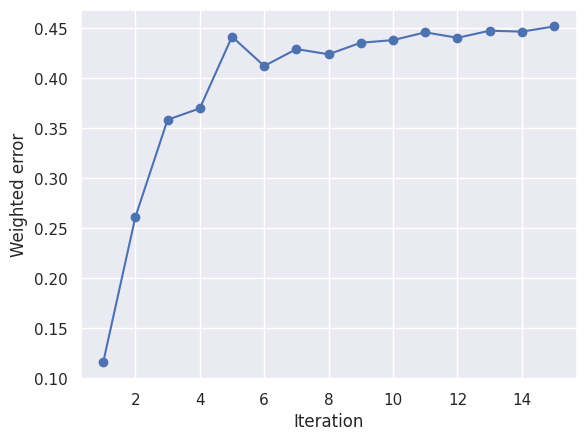

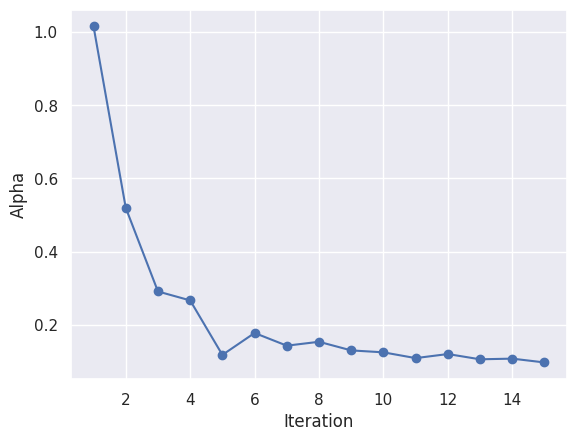

In [5]:
learners, alphas, errors = manual_adaboost(X_train, y_train, T=15, verbose=True)
try:
    y_train_ens = ensemble_predict(learners, alphas, X_train)
    y_test_ens = ensemble_predict(learners, alphas, X_test)
except:
    y_train_ens = ensemble_predict(learners, alphas, X_train.toarray())
    y_test_ens = ensemble_predict(learners, alphas, X_test.toarray())
print_metrics(y_train, y_train_ens, "Train (manual AdaBoost)")
print_metrics(y_test, y_test_ens, "Test (manual AdaBoost)")
plt.figure(); plt.plot(range(1,len(errors)+1), errors, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Weighted error'); plt.show()
plt.figure(); plt.plot(range(1,len(alphas)+1), alphas, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Alpha'); plt.show()


In [6]:
try:
    sk_adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.6, random_state=42)
    sk_adaboost.fit(X_train, y_train)
except:
    sk_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.6, random_state=42)
    sk_adaboost.fit(X_train, y_train)
y_train_sk = sk_adaboost.predict(X_train if not hasattr(X_train,'toarray') else X_train)
y_test_sk = sk_adaboost.predict(X_test if not hasattr(X_test,'toarray') else X_test)
print_metrics(y_train, y_train_sk, "Train (sklearn AdaBoost)")
print_metrics(y_test, y_test_sk, "Test (sklearn AdaBoost)")
print("Manual test acc:", accuracy_score(y_test, y_test_ens))
print("Sklearn test acc:", accuracy_score(y_test, y_test_sk))


Train (sklearn AdaBoost) Accuracy: 0.9161
Confusion matrix:
 [[3842   17]
 [ 357  241]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3859
           1       0.93      0.40      0.56       598

    accuracy                           0.92      4457
   macro avg       0.92      0.70      0.76      4457
weighted avg       0.92      0.92      0.90      4457

Test (sklearn AdaBoost) Accuracy: 0.9247
Confusion matrix:
 [[966   0]
 [ 84  65]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       966
           1       1.00      0.44      0.61       149

    accuracy                           0.92      1115
   macro avg       0.96      0.72      0.78      1115
weighted avg       0.93      0.92      0.91      1115

Manual test acc: 0.9264573991031391
Sklearn test acc: 0.9246636771300448


Q2

In [15]:
!wget -q -O heart.csv https://raw.githubusercontent.com/plotly/datasets/master/heart.csv

In [19]:
import numpy as np
import pandas as pd
import os, re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import files

In [20]:
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(file_name)
df.head()

Saving heart_disease_uci.csv to heart_disease_uci.csv


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [21]:
possible_targets = ['target','class','num','output','disease']
target_col = next((t for t in possible_targets if t in df.columns), df.columns[-1])
df2 = df.copy()
for c in df2.columns:
    if c == target_col:
        continue
    df2[c] = pd.to_numeric(df2[c], errors='coerce')


In [22]:
mapping = {'no':0,'absent':0,'absence':0,'0':0,'negative':0,'yes':1,'present':1,'presence':1,'1':1,'positive':1}
df2[target_col] = df2[target_col].astype(str).str.lower().map(mapping)
df2[target_col] = pd.to_numeric(df2[target_col], errors='coerce')


In [23]:
allnan_cols = df2.columns[df2.isna().all()].tolist()
if allnan_cols:
    df2 = df2.drop(columns=allnan_cols)
df2 = df2.dropna(subset=[target_col])


In [24]:
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target_col]
for c in num_cols:
    if df2[c].isna().any():
        df2[c] = df2[c].fillna(df2[c].median())
cat_cols = df2.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    if df2[c].isna().any():
        df2[c] = df2[c].fillna(df2[c].mode().iloc[0])


In [25]:
Xh = df2.drop(columns=[target_col])
yh = df2[target_col].astype(int)
heur_cat = [c for c in Xh.columns if (Xh[c].nunique() <= 6 and Xh[c].dtype != object)]
heur_cat_obj = [c for c in Xh.columns if Xh[c].dtype == object]
cat_cols_final = sorted(set(heur_cat + heur_cat_obj))
if cat_cols_final:
    Xh_enc = pd.get_dummies(Xh, columns=cat_cols_final, drop_first=True)
else:
    Xh_enc = Xh.copy()


In [26]:
scaler = StandardScaler()
Xh_scaled = scaler.fit_transform(Xh_enc)
Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh_scaled, yh, test_size=0.2, random_state=42, stratify=yh
)
Xh_train.shape, Xh_test.shape


((540, 11), (136, 11))

Q3

In [10]:
from google.colab import files
uploaded = files.upload()
WISDM_PATH = next(iter(uploaded)) if uploaded else 'WISDM_ar_v1.1_raw.txt'
cols=['user_id','activity','timestamp','x','y','z']
wisdm_rows=[]
with open(WISDM_PATH,'r') as f:
    for line in f:
        line=line.strip()
        if not line: continue
        line=line.rstrip(',')
        parts = re.split('[,\\s]+', line)
        if len(parts) < 6: continue
        try:
            user=int(parts[0]); activity=parts[1]; timestamp=int(parts[2])
            x=float(parts[3]); y=float(parts[4]); z=float(parts[5])
            wisdm_rows.append([user, activity, timestamp, x, y, z])
        except:
            continue
df_wisdm = pd.DataFrame(wisdm_rows, columns=cols)
df_wisdm['activity_clean'] = df_wisdm['activity'].str.replace('[^A-Za-z]','',regex=True).str.lower()
def label_activity(a):
    if a in ['jogging','upstairs','up']: return 1
    if a in ['walking','walk','sitting','standing','downstairs','down']: return 0
    return 0
df_wisdm['label'] = df_wisdm['activity_clean'].apply(label_activity)
df_wisdm = df_wisdm.dropna().reset_index(drop=True)
df_wisdm['sample_idx'] = df_wisdm.groupby(['user_id','activity_clean']).cumcount()
window_size = 100
df_wisdm['window_id'] = (df_wisdm['sample_idx'] // window_size)
grouped = df_wisdm.groupby(['user_id','activity_clean','window_id','label'])
feats = grouped.agg({'x':['mean','std','min','max'],'y':['mean','std','min','max'],'z':['mean','std','min','max']})
feats.columns = ['_'.join(col).strip() for col in feats.columns.values]
feats = feats.reset_index()
print("Aggregated windows:", feats.shape)


Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt
Aggregated windows: (119, 16)


In [11]:
Xw = feats[[c for c in feats.columns if c not in ['user_id','activity_clean','window_id','label']]]
yw = feats['label']
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=0.3, random_state=42, stratify=yw)
stump_w = DecisionTreeClassifier(max_depth=1, random_state=42)
stump_w.fit(Xw_train, yw_train)
print_metrics(yw_train, stump_w.predict(Xw_train), "Train (stump)")
print_metrics(yw_test, stump_w.predict(Xw_test), "Test (stump)")


Train (stump) Accuracy: 1.0000
Confusion matrix:
 [[43  0]
 [ 0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        40

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Test (stump) Accuracy: 1.0000
Confusion matrix:
 [[18  0]
 [ 0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



Iteration 1: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 2: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 3: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 4: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 5: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 6: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 7: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 8: weighted_error=0.000000, alpha=13.815511
Misclassified (first 20): []
Weights of first 20 misclassified: []
Iteration 9: weighted_error=0.00

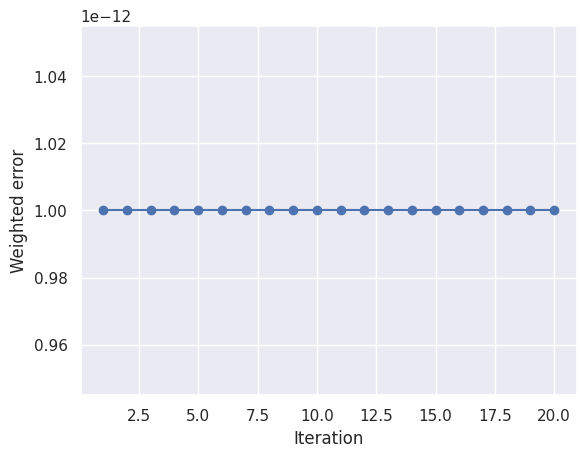

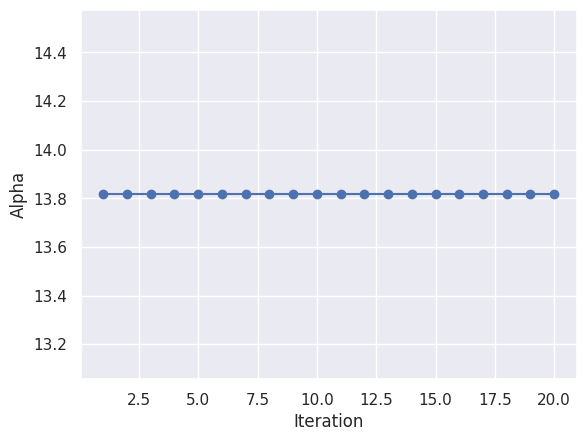

In [12]:
learners_w, alphas_w, errors_w = manual_adaboost(Xw_train.values, yw_train.values, T=20, verbose=True)
yw_train_ens = ensemble_predict(learners_w, alphas_w, Xw_train.values)
yw_test_ens = ensemble_predict(learners_w, alphas_w, Xw_test.values)
print_metrics(yw_train, yw_train_ens, "Train (manual AdaBoost)")
print_metrics(yw_test, yw_test_ens, "Test (manual AdaBoost)")
plt.plot(range(1,len(errors_w)+1), errors_w, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Weighted error'); plt.show()
plt.plot(range(1,len(alphas_w)+1), alphas_w, marker='o'); plt.xlabel('Iteration'); plt.ylabel('Alpha'); plt.show()


In [13]:
try:
    sk_w = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, random_state=42)
    sk_w.fit(Xw_train, yw_train)
except:
    sk_w = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, random_state=42)
    sk_w.fit(Xw_train, yw_train)
print_metrics(yw_train, sk_w.predict(Xw_train), "Train (sklearn AdaBoost)")
print_metrics(yw_test, sk_w.predict(Xw_test), "Test (sklearn AdaBoost)")


Train (sklearn AdaBoost) Accuracy: 1.0000
Confusion matrix:
 [[43  0]
 [ 0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        40

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83

Test (sklearn AdaBoost) Accuracy: 1.0000
Confusion matrix:
 [[18  0]
 [ 0 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

